In [89]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rng
from scipy.special import expit as sigmoid

def load_mnist_digit(digit, dataset_size):
    assert(digit >= 0 and digit < 10)
    with open("datasets/{}.npy".format(digit),'rb') as f:
        return np.load(f)[:dataset_size]
    
def flatten_dataset(images):
    smushed = images.copy()
    return smushed.reshape((smushed.shape[0], -1))

dataset_size = 500  # that's how many of EACH digit there is. Can go as high as... what, 5000?
vis_train_pats = flatten_dataset(load_mnist_digit(0,dataset_size))
for i in [1,2,3,4,5,6,7,8,9]:
    vis_train_pats = np.vstack((vis_train_pats, flatten_dataset(load_mnist_digit(i,dataset_size))))

In [90]:
print (vis_train_pats.shape)
num_pats = vis_train_pats.shape[0]
rand_order = rng.permutation(np.arange(num_pats))
vis_train_pats = vis_train_pats[rand_order]
num_visibles = vis_train_pats.shape[1]
# THIS WRITES LIST OF DIGIT IMAGES AS A CSV TO A PLAIN TXT FILE
# np.savetxt(fname='mnist_500_each_digit.txt', X=vis_train_pats, fmt='%.2f', delimiter=',')

(5000, 784)


## Show some examples....

(5000, 784)


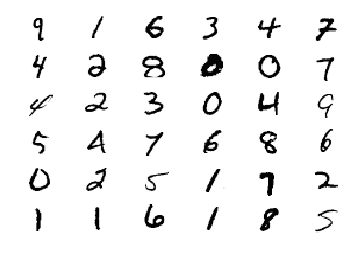

In [91]:
print(vis_train_pats.shape)
i=0
for r in range(6):
    for c in range(6):
        plt.subplot(6,6,i+1)
#        plt.imshow(vis_train_pats[rng.randint(num_pats)].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.imshow(vis_train_pats[i].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.axis('off')
        i += 1

### Start from random initial weights and bias weights

In [92]:
num_hiddens = 200
hid = np.zeros(shape=(num_pats, num_hiddens), dtype=int)
W = 0.5*rng.normal(0,1,size=(num_hiddens, num_visibles))
hid_bias = 0.01*rng.normal(size=(1, num_hiddens))
vis_bias = 0.01*rng.normal(size=(1, num_visibles))
W_change = 0.0
hid_bias_change = 0.0
vis_bias_change = 0.0

In [93]:
print(vis_train_pats.shape)

(5000, 784)


### Do some learning, using CD1 (contrastive divergence)

In [125]:
num_iterations = 1000
announce_every = num_iterations / 10
learning_rate, momentum = 0.001, 0.9
import time
start = time.time()

rand_order = rng.permutation(np.arange(num_pats))
minibatch_size = 100

for t in range(num_iterations+1):
    start_index = 0
    while start_index < num_pats-1:
        #print('start index: %d' % start_index)
        next_index = min(start_index + minibatch_size, num_pats)
        vis_minibatch = vis_train_pats[start_index:next_index]
        start_index = next_index  # ready for next time
        
        # push visible pats into hidden 
        hid_prob1 = sigmoid(np.dot(vis_minibatch, W.T) + hid_bias)
        hid_first = 1*(hid_prob1 > rng.random(size=hid_prob1.shape))

        # push hidden pats into visible 
        vis_prob1 = sigmoid(np.dot(hid_first, W) + vis_bias)
        vis_reconstruction = vis_prob1  # = 1*(v_prob1 > rng.random(size=v_prob1.shape))

        # push visible pats into hidden 
        hid_prob1 = sigmoid(np.dot(vis_reconstruction, W.T) + hid_bias)
        hid_second = 1*(hid_prob1 > rng.random(size=hid_prob1.shape))

        # THIS WAY IS REALLY MEMORY-INTENSIVE AND SLOW - USE EINSTEIN INSTEAD!
        # Hebb = ((np.array([h_first]*num_visibles).T)  * (np.array([v]*num_hiddens))).sum(1)
        # AntiHebb = ((np.array([h_second]*num_visibles).T)  * (np.array([v_reconstruction]*num_hiddens))).sum(1)

        # Einstein alternative suggested by Paul Mathews.
        Hebb = np.einsum('ij,ik->jk', hid_first, vis_minibatch) 
        AntiHebb = np.einsum('ij,ik->jk', hid_second, vis_reconstruction) 

        W_change = learning_rate * (Hebb - AntiHebb)  +  momentum * W_change
        W += W_change #- sparse_penalty * TODO TODO TODO TODO TODO

        # Now we have to do the visible and hidden bias weights as well.
        hid_bias_change = learning_rate * (hid_first.sum(0) - hid_second.sum(0))   +  momentum * hid_bias_change
        hid_bias += hid_bias_change
        vis_bias_change = learning_rate * (vis_minibatch.sum(0) - vis_reconstruction.sum(0))   +  momentum * vis_bias_change
        vis_bias += vis_bias_change
    
    if (t % announce_every == 0): 
        print ('Iteration %5d \t TIME (secs): %.1f ' % (t, time.time() - start))

Iteration     0 	 TIME (secs): 10.9 
Iteration   100 	 TIME (secs): 1089.5 
Iteration   200 	 TIME (secs): 2168.9 
Iteration   300 	 TIME (secs): 3243.6 
Iteration   400 	 TIME (secs): 4319.0 
Iteration   500 	 TIME (secs): 5394.9 
Iteration   600 	 TIME (secs): 6469.9 
Iteration   700 	 TIME (secs): 7546.4 
Iteration   800 	 TIME (secs): 8622.0 
Iteration   900 	 TIME (secs): 9698.5 
Iteration  1000 	 TIME (secs): 10773.4 


### reality-check some of the latest Hebb updates 

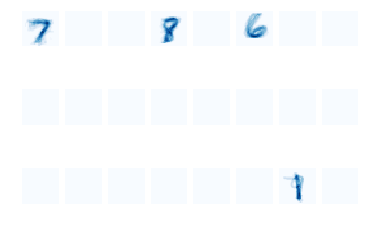

In [134]:
nr, nc = 3, 8
for i in range(nr*nc):
    plt.subplot(nr,nc,i+1)
    plt.imshow(Hebb[i].reshape(28,28), interpolation='nearest',cmap='Blues')
    plt.axis('off')

### .... and some of the latest ANTI-Hebbian updates 

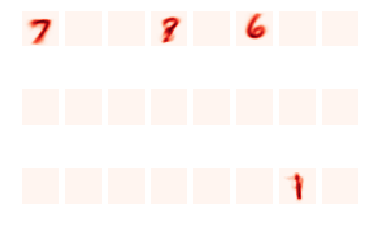

In [135]:
for i in range(nr*nc):
    plt.subplot(nr,nc,i+1)
    plt.imshow(AntiHebb[i].reshape(28,28), interpolation='nearest',cmap='Reds')
    plt.axis('off')

## features (ie. the current weights...)
I could draw the visible bias weights as an image here too....

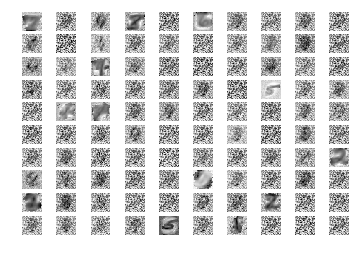

In [136]:
i=0
for r in range(10):
    for c in range(10):
        plt.subplot(10,10,i+1)
        plt.imshow(W[i].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.axis('off')
        i += 1

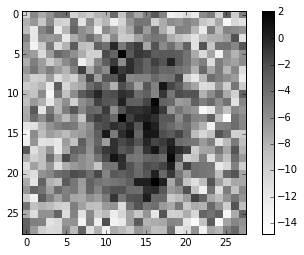

In [145]:
# show random ones, large...
plt.imshow(W[rng.randint(num_hiddens)].reshape(28,28), cmap='Greys', interpolation='nearest')
plt.colorbar()

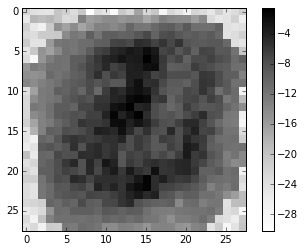

In [146]:
# show biases into the visible units
plt.imshow(vis_bias.reshape(28,28), cmap='Greys', interpolation='nearest')
plt.colorbar()

## dreams
I think I'll try some "dreams" that start on actual training patterns.
I'll show them (but less and less often) as the Gibbs chain random-walks away from this initial point, and see how they diverge, and what they diverge TO.

So, presumably we should see them falling away from their initial state into the land of dreams as the model loses track of where it started from.

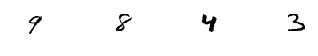

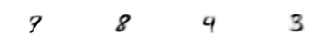

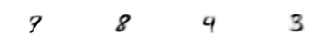

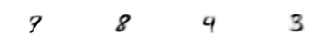

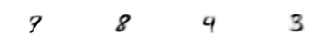

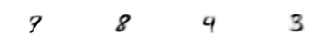

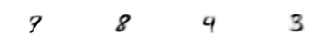

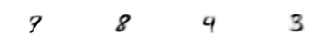

In [131]:
num_examples = 4
Vis_test = np.copy(vis_train_pats[rng.randint(0, num_pats, size=(num_examples)), :])
i = 0
num_Gibbs = 0
num_rows = 8
for s in range(num_rows):
    for t in range(num_Gibbs):
        # push visible pats into hidden 
        hid_prob1 = sigmoid(np.dot(Vis_test, W.T) + hid_bias)
        hid = 1*(hid_prob1 > rng.random(size=hid_prob1.shape))
        # push hidden pats into visible 
        vis_prob1 = sigmoid(np.dot(hid, W) + vis_bias)
        Vis_test = vis_prob1  # OR....  1*(v_prob1 > rng.random(size=v_prob1.shape))
    for n in range(num_examples):
        i += 1
        plt.subplot(num_rows,num_examples,i)
        plt.imshow(Vis_test[n].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.axis('off')
        
    num_Gibbs = max(1, num_Gibbs * 4)  # wait X times longer each time before showing the next sample.
    plt.show()

And now starting from some truly random initial patterns..............

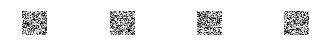

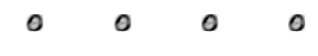

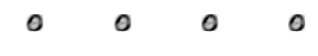

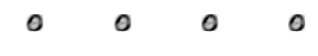

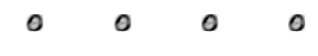

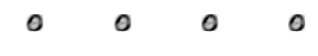

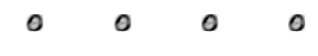

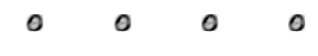

In [132]:
num_examples = 4
Vis_test = rng.random(size=(num_examples, num_visibles))
i = 0
num_Gibbs = 0
num_rows = 8
for s in range(num_rows):
    for t in range(num_Gibbs):
        # push visible pats into hidden 
        hid_prob1 = sigmoid(np.dot(Vis_test, W.T) + hid_bias)
        hid = 1*(hid_prob1 > rng.random(size=hid_prob1.shape))
        # push hidden pats into visible 
        vis_prob1 = sigmoid(np.dot(hid, W) + vis_bias)
        Vis_test = vis_prob1  # OR....  1*(v_prob1 > rng.random(size=v_prob1.shape))
    for n in range(num_examples):
        i += 1
        plt.subplot(num_rows,num_examples,i)
        plt.imshow(Vis_test[n].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.axis('off')
        
    num_Gibbs = max(1, num_Gibbs * 4)  # wait longer before showing the next sample...
    plt.show()

In [147]:
np.savez('./RBM_weights.npz', W=W, hid_bias=hid_bias, vis_bias=vis_bias)